In [1]:
import warnings
warnings.filterwarnings('ignore')

# Using Text Data with EvalML

In this demo, we will show you how to use EvalML to build models which use text data. 

In [2]:
import evalml
from evalml import AutoMLSearch

## Dataset

We will be utilizing a dataset of SMS text messages, some of which are categorized as spam, and others which are not ("ham"). This dataset is originally from [Kaggle](https://www.kaggle.com/uciml/sms-spam-collection-dataset), but modified to produce a slightly more even distribution of spam to ham.

In [3]:
from urllib.request import urlopen
import pandas as pd

input_data = urlopen('https://featurelabs-static.s3.amazonaws.com/spam_text_messages_modified.csv')
data = pd.read_csv(input_data)

X = data.drop(['Category'], axis=1)
y = data['Category']

display(X.head())

,Message
0,Free entry in 2 a wkly comp to win FA Cup fina...
1,FreeMsg Hey there darling it's been 3 week's n...
2,WINNER!! As a valued network customer you have...
3,Had your mobile 11 months or more? U R entitle...
4,"SIX chances to win CASH! From 100 to 20,000 po..."


The ham vs spam distribution of the data is 3:1, so any machine learning model must get above 75% [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification) in order to perform better than a trivial baseline model which simply classifies everything as ham. 

In [4]:
y.value_counts(normalize=True)

ham     0.750084
spam    0.249916
Name: Category, dtype: float64

## Search for best pipeline

In order to validate the results of the pipeline creation and optimization process, we will save some of our data as a holdout set.

In [5]:
X_train, X_holdout, y_train, y_holdout = evalml.preprocessing.split_data(X, y, problem_type='binary', test_size=0.2, random_seed=0)

EvalML uses [Woodwork](https://woodwork.alteryx.com/en/stable/) to automatically detect which columns are text columns, so you can run search normally, as you would if there was no text data. We can print out the logical type of the `Message` column and assert that it is indeed inferred as a natural language column.

In [6]:
X_train.ww.types

,Physical Type,Logical Type,Semantic Tag(s)
Column,,,
Message,string,NaturalLanguage,[]


Because the spam/ham labels are binary, we will use `AutoMLSearch(X_train=X_train, y_train=y_train, problem_type='binary')`. When we call `.search()`, the search for the best pipeline will begin. 

In [7]:
automl = AutoMLSearch(X_train=X_train, y_train=y_train,
                      problem_type='binary',
                      max_batches=1,
                      optimize_thresholds=True)

automl.search()

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Binary. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 1 batches for a total of 9 pipelines. 
Allowed model families: decision_tree, random_forest, catboost, lightgbm, xgboost, linear_model, extra_trees



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/9) Mode Baseline Binary Classification P... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 8.638
Batch 1: (2/9) Decision Tree Classifier w/ Text Feat... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.802
High coefficient of variation (cv >= 0.2) within cross validation scores. Decision Tree Classifier w/ Text Featurization Component may not perform as estimated on unseen data.
Batch 1: (3/9) LightGBM Classifier w/ Text Featuriza... Elapsed:00:10
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.215
High coefficient of variation (cv >= 0.2) within cross validation scores. LightGBM Classifier w/ Text Featurization Component may not perform as estimated on unseen data.
Batch 1: (4/9) Extra Trees Classifier w/ Text Featur... Elapsed:00:19
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.252
High coefficient of variation (cv >= 

### View rankings and select pipeline

Once the fitting process is done, we can see all of the pipelines that were searched.

In [8]:
automl.rankings

,id,pipeline_name,score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,7,Random Forest Classifier w/ Text Featurization...,0.154849,0.110302,98.207418,True,{'Random Forest Classifier': {'n_estimators': ...
1,6,XGBoost Classifier w/ Text Featurization Compo...,0.178639,0.113254,97.932010,True,"{'XGBoost Classifier': {'eta': 0.1, 'max_depth..."
2,8,Logistic Regression Classifier w/ Text Featuri...,0.214011,0.165624,97.522538,True,{'Logistic Regression Classifier': {'penalty':...
3,2,LightGBM Classifier w/ Text Featurization Comp...,0.214580,0.136260,97.515944,True,{'LightGBM Classifier': {'boosting_type': 'gbd...
4,3,Extra Trees Classifier w/ Text Featurization C...,0.252206,0.216198,97.080377,True,{'Extra Trees Classifier': {'n_estimators': 10...
5,5,CatBoost Classifier w/ Text Featurization Comp...,0.526403,0.512717,93.906174,False,"{'CatBoost Classifier': {'n_estimators': 10, '..."
6,4,Elastic Net Classifier w/ Text Featurization C...,0.542803,0.529152,93.716325,False,"{'Elastic Net Classifier': {'alpha': 0.5, 'l1_..."
7,1,Decision Tree Classifier w/ Text Featurization...,0.801766,0.555179,90.718481,True,{'Decision Tree Classifier': {'criterion': 'gi...
8,0,Mode Baseline Binary Classification Pipeline,8.638305,8.623860,0.000000,False,{'Baseline Classifier': {'strategy': 'mode'}}


To select the best pipeline we can call `automl.best_pipeline`.

In [9]:
best_pipeline = automl.best_pipeline

### Describe pipeline

You can get more details about any pipeline, including how it performed on other objective functions.

In [10]:
automl.describe_pipeline(automl.rankings.iloc[0]["id"])

************************************************************
* Random Forest Classifier w/ Text Featurization Component *
************************************************************

Problem Type: binary
Model Family: Random Forest

Pipeline Steps
1. Text Featurization Component
2. Random Forest Classifier
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1

Training
Training for binary problems.
Total training time (including CV): 8.5 seconds

Cross Validation
----------------
             Log Loss Binary  MCC Binary   AUC  Precision    F1  Balanced Accuracy Binary  Accuracy Binary # Training # Validation
0                      0.110       0.895 0.987      0.938 0.921                     0.942            0.961     1594.0        797.0
1                      0.144       0.854 0.980      0.919 0.888                     0.917            0.946     1594.0        797.0
2                      0.210       0.783 0.962      0.839 0.837                     0.891            0.918     1594.0 

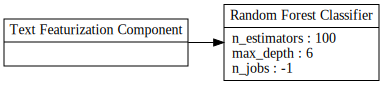

In [11]:
best_pipeline.graph()

Notice above that there is a `Text Featurization Component` as the second step in the pipeline. The Woodwork `DataTable` passed in to AutoML search recognizes that `'Message'` is a text column, and converts this text into numerical values that can be handled by the estimator.

## Evaluate on holdout

Now, we can score the pipeline on the holdout data using the core objectives for binary classification problems.

In [12]:
scores = best_pipeline.score(X_holdout, y_holdout,  objectives=evalml.objectives.get_core_objectives('binary'))
print(f'Accuracy Binary: {scores["Accuracy Binary"]}')

Accuracy Binary: 0.9732441471571907


As you can see, this model performs relatively well on this dataset, even on unseen data.

## Why encode text this way?

To demonstrate the importance of text-specific modeling, let's train a model with the same dataset, without letting `AutoMLSearch` detect the text column. We can change this by explicitly setting the data type of the `'Message'` column in Woodwork to `Categorical` using the utility method `infer_feature_types`.

In [13]:
from evalml.utils import infer_feature_types
X = infer_feature_types(X, {'Message': 'Categorical'})
X_train, X_holdout, y_train, y_holdout = evalml.preprocessing.split_data(X, y, problem_type='binary', test_size=0.2, random_seed=0)

In [14]:
automl_no_text = AutoMLSearch(X_train=X_train, y_train=y_train,
                              problem_type='binary',
                              max_batches=1,
                              optimize_thresholds=True)

automl_no_text.search()

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Binary. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 1 batches for a total of 9 pipelines. 
Allowed model families: decision_tree, random_forest, catboost, lightgbm, xgboost, linear_model, extra_trees



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/9) Mode Baseline Binary Classification P... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 8.638
Batch 1: (2/9) Decision Tree Classifier w/ Imputer +... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.561
Batch 1: (3/9) LightGBM Classifier w/ Imputer + One ... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.562
Batch 1: (4/9) Extra Trees Classifier w/ Imputer + O... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.561
Batch 1: (5/9) Elastic Net Classifier w/ Imputer + O... Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.563
Batch 1: (6/9) CatBoost Classifier w/ Imputer           Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 0.622
Batch 1: (7/9) XGBoost Classifier w/ Imputer + One H... Elapsed:00:02
	Start

Like before, we can look at the rankings and pick the best pipeline.

In [15]:
automl_no_text.rankings

,id,pipeline_name,score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,8,Logistic Regression Classifier w/ Imputer + On...,0.560554,0.558141,93.510838,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,1,Decision Tree Classifier w/ Imputer + One Hot ...,0.561003,0.558148,93.505636,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,7,Random Forest Classifier w/ Imputer + One Hot ...,0.561179,0.559141,93.503593,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,3,Extra Trees Classifier w/ Imputer + One Hot En...,0.561247,0.559029,93.502811,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,6,XGBoost Classifier w/ Imputer + One Hot Encoder,0.562197,0.561991,93.491811,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,2,LightGBM Classifier w/ Imputer + One Hot Encoder,0.562451,0.561991,93.488872,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,4,Elastic Net Classifier w/ Imputer + One Hot En...,0.562556,0.562070,93.487658,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,5,CatBoost Classifier w/ Imputer,0.622449,0.622812,92.794318,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,0,Mode Baseline Binary Classification Pipeline,8.638305,8.623860,0.000000,False,{'Baseline Classifier': {'strategy': 'mode'}}


In [16]:
best_pipeline_no_text = automl_no_text.best_pipeline

Here, changing the data type of the text column removed the `Text Featurization Component` from the pipeline.

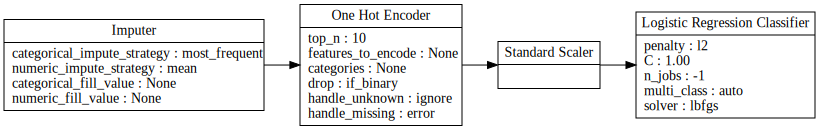

In [17]:
best_pipeline_no_text.graph()

In [18]:
automl_no_text.describe_pipeline(automl_no_text.rankings.iloc[0]["id"])

*********************************************************************************
* Logistic Regression Classifier w/ Imputer + One Hot Encoder + Standard Scaler *
*********************************************************************************

Problem Type: binary
Model Family: Linear

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. One Hot Encoder
	 * top_n : 10
	 * features_to_encode : None
	 * categories : None
	 * drop : if_binary
	 * handle_unknown : ignore
	 * handle_missing : error
3. Standard Scaler
4. Logistic Regression Classifier
	 * penalty : l2
	 * C : 1.0
	 * n_jobs : -1
	 * multi_class : auto
	 * solver : lbfgs

Training
Training for binary problems.
Total training time (including CV): 1.4 seconds

Cross Validation
----------------
             Log Loss Binary  MCC Binary   AUC  Precision    F1  Balanced Accuracy Binary  Accuracy Binary # Tra

In [19]:
# get standard performance metrics on holdout data
scores = best_pipeline_no_text.score(X_holdout, y_holdout, objectives=evalml.objectives.get_core_objectives('binary'))
print(f'Accuracy Binary: {scores["Accuracy Binary"]}')

Accuracy Binary: 0.7525083612040134


Without the `Text Featurization Component`, the `'Message'` column was treated as a categorical column, and therefore the conversion of this text to numerical features happened in the `One Hot Encoder`. The best pipeline encoded the top 10 most frequent "categories" of these texts, meaning 10 text messages were one-hot encoded and all the others were dropped. Clearly, this removed almost all of the information from the dataset, as we can see the `best_pipeline_no_text` did not beat the random guess of predicting "ham" in every case.